# 1. Загрузка данных

In [1]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.model_selection import cross_validate

In [2]:
df1 = pd.read_csv(r"../../data/trip_duration_processed.csv")

In [3]:
df2 = pd.read_csv(r"../../data/airlines_label_encoding.csv")

In [4]:
df2["Delay"].value_counts()

Delay
0    159671
1     82058
Name: count, dtype: int64

In [5]:
rus = RandomUnderSampler()
X_cl, y_cl = rus.fit_resample(df2.drop(columns=["Delay"], axis=1), df2["Delay"])
X_cl = X_cl.drop(columns=["Unnamed: 0"], axis=1)

In [6]:
X_train_cl_hold, X_test_cl_hold, y_train_cl_hold, y_test_cl_hold = train_test_split(X_cl, y_cl, train_size=0.8)

In [7]:
y_train_cl_hold.value_counts()

Delay
1    65734
0    65558
Name: count, dtype: int64

In [8]:
X_reg = df1.drop(columns=["trip_duration", "Unnamed: 0"])
y_reg = df1["trip_duration"]

In [9]:
X_train_reg_hold, X_test_reg_hold, y_train_reg_hold, y_test_reg_hold = train_test_split(X_reg, y_reg, train_size=0.8)

In [10]:
X_cl.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length
67788,202,4576,168,64,1,370,120.0
152349,202,4231,64,220,5,1080,145.0
234052,303,971,225,228,5,590,165.0
90089,111,50,163,19,1,861,249.0
120777,0,3888,186,37,5,855,63.0


In [11]:
X_reg.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_day,trip_month,trip_hour,distance,vendor_id_1,vendor_id_2
0,1,-73.953918,40.778873,-73.963875,40.771164,1,2,16,0.012592,0,1
1,2,-73.988312,40.731743,-73.994751,40.694931,5,3,23,0.037371,1,0
2,2,-73.997314,40.721458,-73.948029,40.774918,7,2,17,0.072712,0,1
3,6,-73.961670,40.759720,-73.956779,40.780628,2,1,9,0.021473,0,1
4,1,-74.017120,40.708469,-73.988182,40.740631,3,2,6,0.043264,1,0


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

In [13]:
def classification_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [14]:
def print_scores(scores):
    for k, v in scores.items():
        print(f"{k}: {round(v, 2)}")

In [15]:
def cv_classification_scores(scores):
    return {
        "accuracy": scores["test_accuracy"].mean(),
        "precision": scores["test_precision"].mean(),
        "recall": scores["test_recall"].mean(),
        "f1": scores["test_f1"].mean(),
    }

In [16]:
def cv_regression_scores(scores):
    return {
        "MSE": -scores["test_neg_mean_squared_error"].mean(),
        "MAE": -scores["test_neg_mean_absolute_error"].mean(),
        "RMSE": -scores["test_neg_root_mean_squared_error"].mean(),
        "MAPE": -scores["test_neg_mean_absolute_percentage_error"].mean(),
        "R2": scores["test_r2"].mean()
    }

# 2. Использование DecisionTree для классификации

In [17]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Модель до регуляризации

### Результаты на тестовой выборке

In [18]:
dtc_non_regularization = DecisionTreeClassifier().fit(X_train_cl_hold, y_train_cl_hold)

In [19]:
y_pred_non_regular_dtc_test = dtc_non_regularization.predict(X_test_cl_hold)

In [20]:
dtc_non_reg_scores_test = classification_scores(y_test_cl_hold, y_pred_non_regular_dtc_test)

In [21]:
print("Результаты на тестовой выборке")
print_scores(dtc_non_reg_scores_test)
print(confusion_matrix(y_test_cl_hold, y_pred_non_regular_dtc_test))

Результаты на тестовой выборке
accuracy: 0.47
precision: 0.47
recall: 0.44
f1: 0.45
[[8350 8150]
 [9167 7157]]


### Результаты на тренировочной выборке

In [22]:
y_pred_non_regular_dtc_train = dtc_non_regularization.predict(X_train_cl_hold)

In [23]:
dtc_non_reg_scores_train = classification_scores(y_train_cl_hold, y_pred_non_regular_dtc_train)

In [24]:
print("Результаты на тренировочной выборке")
print_scores(dtc_non_reg_scores_train)
print(confusion_matrix(y_train_cl_hold, y_pred_non_regular_dtc_train))

Результаты на тренировочной выборке
accuracy: 0.9
precision: 1.0
recall: 0.79
f1: 0.88
[[65558     0]
 [13694 52040]]


## GridSearch

In [25]:
dtc_grid_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(6, 12),
    "min_samples_split": np.arange(2, 5),
    "min_samples_leaf": np.arange(1, 5)
}

In [26]:
dtc_grid = GridSearchCV(DecisionTreeClassifier(), dtc_grid_params, n_jobs=-1).fit(X_train_cl_hold, y_train_cl_hold)

In [27]:
dtc_grid.best_params_

{'criterion': 'gini',
 'max_depth': np.int64(8),
 'min_samples_leaf': np.int64(3),
 'min_samples_split': np.int64(3)}

### Результаты на тестовой выборке

In [28]:
y_pred_grid_dtc_test = dtc_grid.predict(X_test_cl_hold)

In [29]:
dtc_grid_scores_test = classification_scores(y_test_cl_hold, y_pred_grid_dtc_test)

In [30]:
print("Результаты на тестовой выборке")
print_scores(dtc_grid_scores_test)
print(confusion_matrix(y_test_cl_hold, y_pred_grid_dtc_test))

Результаты на тестовой выборке
accuracy: 0.63
precision: 0.63
recall: 0.61
f1: 0.62
[[10642  5858]
 [ 6426  9898]]


### Результаты на тренировочной выборке

In [31]:
y_pred_grid_dtc_train = dtc_grid.predict(X_train_cl_hold)

In [32]:
dtc_grid_scores_train = classification_scores(y_train_cl_hold, y_pred_grid_dtc_train)

In [33]:
print("Результаты на тренировочной выборке")
print_scores(dtc_grid_scores_train)
print(confusion_matrix(y_train_cl_hold, y_pred_grid_dtc_train))

Результаты на тренировочной выборке
accuracy: 0.63
precision: 0.63
recall: 0.61
f1: 0.62
[[42216 23342]
 [25567 40167]]


## RandomizedSearch

In [34]:
dtc_rand_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(2, 50),
    "min_samples_split": np.arange(2, 50),
    "min_samples_leaf": np.arange(1, 50)
}

In [35]:
dtc_rand = RandomizedSearchCV(DecisionTreeClassifier(), dtc_rand_params, n_jobs=-1).fit(X_train_cl_hold, y_train_cl_hold)

In [36]:
dtc_rand.best_params_

{'min_samples_split': np.int64(25),
 'min_samples_leaf': np.int64(29),
 'max_depth': np.int64(8),
 'criterion': 'gini'}

### Результаты на тестовой выборке

In [37]:
y_pred_rand_dtc_test = dtc_rand.predict(X_test_cl_hold)

In [38]:
dtc_rand_scores_test = classification_scores(y_test_cl_hold, y_pred_rand_dtc_test)

In [39]:
print("Результаты на тестовой выборке")
print_scores(dtc_rand_scores_test)
print(confusion_matrix(y_test_cl_hold, y_pred_rand_dtc_test))

Результаты на тестовой выборке
accuracy: 0.63
precision: 0.63
recall: 0.61
f1: 0.62
[[10620  5880]
 [ 6391  9933]]


### Результаты на тренировочной выборке

In [40]:
y_pred_rand_dtc_train = dtc_rand.predict(X_train_cl_hold)

In [41]:
dtc_rand_scores_test = classification_scores(y_train_cl_hold, y_pred_rand_dtc_train)

In [42]:
print("Результаты на тренировочной выборке")
print_scores(dtc_rand_scores_test)
print(confusion_matrix(y_train_cl_hold, y_pred_rand_dtc_train))

Результаты на тренировочной выборке
accuracy: 0.63
precision: 0.63
recall: 0.61
f1: 0.62
[[42099 23459]
 [25502 40232]]


## Итоговая модель DecisionTree с лучшими параметрами

In [43]:
dtc = dtc_rand

In [44]:
with open(r"../../models/Lab4 (Tree)/DecisionTreeCl.pkl", "wb") as f:
    pickle.dump(dtc, f)

In [45]:
y_pred_dtc_hold_test = dtc.predict(X_test_cl_hold)

## Decision Tree Classifier на тестовых данных

In [46]:
dtc_hold_scores_test = classification_scores(y_test_cl_hold, y_pred_dtc_hold_test)

In [47]:
print("Результаты на тестовой выборке")
print_scores(dtc_hold_scores_test)
print(confusion_matrix(y_test_cl_hold, y_pred_dtc_hold_test))

Результаты на тестовой выборке
accuracy: 0.63
precision: 0.63
recall: 0.61
f1: 0.62
[[10620  5880]
 [ 6391  9933]]


## Decision Tree Classifier на тренировочных данных

In [48]:
y_pred_dtc_hold_train = dtc.predict(X_train_cl_hold)

In [49]:
dtc_hold_scores_train = classification_scores(y_train_cl_hold, y_pred_dtc_hold_train)

In [50]:
print("Результаты на тренировочной выборке")
print_scores(dtc_hold_scores_train)
print(confusion_matrix(y_train_cl_hold, y_pred_dtc_hold_train))

Результаты на тренировочной выборке
accuracy: 0.63
precision: 0.63
recall: 0.61
f1: 0.62
[[42099 23459]
 [25502 40232]]


## Decision Tree Classifier с кросс-валидацией

In [51]:
skf = StratifiedKFold(n_splits=10)

In [52]:
dtc_train_scores_cross = []
dtc_test_scores_cross = []
dtc_cross = dtc

In [53]:
for train_index, test_index in skf.split(X_cl, y_cl):
    X_train_cl_cross = X_cl.iloc[train_index].values
    X_test_cl_cross = X_cl.iloc[test_index].values
    y_train_cl_cross = y_cl.iloc[train_index].values
    y_test_cl_cross = y_cl.iloc[test_index].values
    
    dtc_cross.fit(X_train_cl_cross, y_train_cl_cross)
    y_pred_cl_cross_test = dtc_cross.predict(X_test_cl_cross)
    dtc_test_scores_cross.append(classification_scores(y_test_cl_cross, y_pred_cl_cross_test))

    y_pred_cl_cross_train = dtc_cross.predict(X_train_cl_cross)
    dtc_train_scores_cross.append(classification_scores(y_train_cl_cross, y_pred_cl_cross_train))

In [54]:
def mean_cross_validate_scores(cross_val_scores):
    keys = list(cross_val_scores[0].keys())
    n = len(keys)
    m = len(cross_val_scores)
    scores = [list(x.values()) for x in cross_val_scores]
    scores = np.array(list(map(lambda x: np.array(x), scores)))
    
    mean_scores = np.sum(scores, axis=0) / m
    mean_scores = np.round(mean_scores, 2)
    mean_scores = mean_scores.tolist()
    return {keys[i]: mean_scores[i] for i in range(n)}

## Decision Tree Classifier с кросс-валидацией на тестовых данных

In [55]:
dtc_test_cross_val = mean_cross_validate_scores(dtc_test_scores_cross)

In [56]:
print("Результаты на тестовой выборке")
print_scores(dtc_test_cross_val)

Результаты на тестовой выборке
accuracy: 0.61
precision: 0.62
recall: 0.59
f1: 0.6


## Decision Tree Classifier с кросс-валидацией на тренировочных данных

In [57]:
dtc_train_cross_val = mean_cross_validate_scores(dtc_train_scores_cross)

In [58]:
print("Результаты на тренировочной выборке")
print_scores(dtc_train_cross_val)

Результаты на тренировочной выборке
accuracy: 0.63
precision: 0.63
recall: 0.61
f1: 0.62


# 3. Использование DecisionTree для регрессии

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

In [60]:
def regression_scores(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"mse": mse, "mae": mae, "mape": mape, "rmse": rmse, "r2": r2}

## Модель до регуляризации

### Результаты на тестовой выборке

In [61]:
dtr_non_regularization = DecisionTreeRegressor().fit(X_train_reg_hold, y_train_reg_hold)

In [62]:
y_pred_non_regular_dtr_test = dtr_non_regularization.predict(X_test_reg_hold)

In [63]:
dtr_non_reg_scores_test = regression_scores(y_test_reg_hold, y_pred_non_regular_dtr_test)

In [64]:
print("Результаты на тестовой выборке")
print_scores(dtr_non_reg_scores_test)

Результаты на тестовой выборке
mse: 95188.3
mae: 219.6
mape: 0.45
rmse: 308.53
r2: 0.42


### Результаты на тренировочной выборке

In [65]:
y_pred_non_regular_dtr_train = dtr_non_regularization.predict(X_train_reg_hold)

In [66]:
dtr_non_reg_scores_train = regression_scores(y_train_reg_hold, y_pred_non_regular_dtr_train)

In [67]:
print("Результаты на тренировочной выборке")
print_scores(dtr_non_reg_scores_train)

Результаты на тренировочной выборке
mse: 0.0
mae: 0.0
mape: 0.0
rmse: 0.0
r2: 1.0


## GridSearch

In [68]:
dtr_grid_params = {
    "criterion": ["squared_error"],
    "max_depth": np.arange(6, 12),
    "min_samples_split": np.arange(2, 5),
    "min_samples_leaf": np.arange(1, 5)
}

In [69]:
dtr_grid = GridSearchCV(DecisionTreeRegressor(), dtr_grid_params, n_jobs=-1).fit(X_train_reg_hold, y_train_reg_hold)

In [70]:
dtr_grid.best_params_

{'criterion': 'squared_error',
 'max_depth': np.int64(11),
 'min_samples_leaf': np.int64(4),
 'min_samples_split': np.int64(4)}

### Результаты на тестовой выборке

In [71]:
y_pred_grid_dtr_test = dtr_grid.predict(X_test_reg_hold)

In [72]:
dtr_grid_scores_test = regression_scores(y_test_reg_hold, y_pred_grid_dtr_test)

In [73]:
print("Результаты на тестовой выборке")
print_scores(dtr_grid_scores_test)

Результаты на тестовой выборке
mse: 59098.63
mae: 176.86
mape: 0.39
rmse: 243.1
r2: 0.64


### Результаты на тренировочной выборке

In [74]:
y_pred_grid_dtr_train = dtr_grid.predict(X_train_reg_hold)

In [75]:
dtr_grid_scores_train = regression_scores(y_train_reg_hold, y_pred_grid_dtr_train)

In [76]:
print("Результаты на тренировочной выборке")
print_scores(dtr_grid_scores_train)

Результаты на тренировочной выборке
mse: 56686.91
mae: 173.0
mape: 0.38
rmse: 238.09
r2: 0.66


## RandomizedSearch

In [77]:
dtr_rand_params = {
    "criterion": ["squared_error"],
    "max_depth": np.arange(2, 50),
    "min_samples_split": np.arange(2, 50),
    "min_samples_leaf": np.arange(1, 50)
}

In [78]:
dtr_rand = RandomizedSearchCV(DecisionTreeRegressor(), dtr_rand_params, n_jobs=-1).fit(X_train_reg_hold, y_train_reg_hold)

In [79]:
dtr_rand.best_params_

{'min_samples_split': np.int64(3),
 'min_samples_leaf': np.int64(45),
 'max_depth': np.int64(37),
 'criterion': 'squared_error'}

### Результаты на тестовой выборке

In [80]:
y_pred_rand_dtr_test = dtr_rand.predict(X_test_reg_hold)

In [81]:
dtr_rand_scores_test = regression_scores(y_test_reg_hold, y_pred_rand_dtr_test)

In [82]:
print("Результаты на тестовой выборке")
print_scores(dtr_rand_scores_test)

Результаты на тестовой выборке
mse: 54849.18
mae: 169.63
mape: 0.37
rmse: 234.2
r2: 0.67


### Результаты на тренировочной выборке

In [83]:
y_pred_rand_dtr_train = dtr_rand.predict(X_train_reg_hold)

In [84]:
dtc_rand_scores_test = regression_scores(y_train_reg_hold, y_pred_rand_dtr_train)

In [85]:
print("Результаты на тренировочной выборке")
print_scores(dtc_rand_scores_test)

Результаты на тренировочной выборке
mse: 46460.28
mae: 155.69
mape: 0.34
rmse: 215.55
r2: 0.72


## Итоговая модель DecisionTree с лучшими параметрами

In [86]:
dtr = dtr_rand

In [87]:
with open(r"../../models/Lab4 (Tree)/DecisionTreeReg.pkl", "wb") as f:
    pickle.dump(dtr, f)

In [88]:
y_pred_dtr_hold_test = dtr.predict(X_test_reg_hold)

## Decision Tree Regressor на тестовых данных

In [89]:
dtr_hold_scores_test = regression_scores(y_test_reg_hold, y_pred_dtr_hold_test)

In [90]:
print("Результаты на тестовой выборке")
print_scores(dtr_hold_scores_test)

Результаты на тестовой выборке
mse: 54849.18
mae: 169.63
mape: 0.37
rmse: 234.2
r2: 0.67


## Decision Tree Regressor на тренировочных данных

In [91]:
y_pred_dtr_hold_train = dtr.predict(X_train_reg_hold)

In [92]:
dtr_hold_scores_train = regression_scores(y_train_reg_hold, y_pred_dtr_hold_train)

In [93]:
print("Результаты на тренировочной выборке")
print_scores(dtr_hold_scores_train)

Результаты на тренировочной выборке
mse: 46460.28
mae: 155.69
mape: 0.34
rmse: 215.55
r2: 0.72


## Decision Tree Regressor с кросс-валидацией

In [94]:
skf = StratifiedKFold(n_splits=10)

In [95]:
dtr_train_scores_cross = []
dtr_test_scores_cross = []
dtr_cross = dtr

In [96]:
for train_index, test_index in skf.split(X_reg, y_reg):
    X_train_reg_cross = X_reg.iloc[train_index].values
    X_test_reg_cross = X_reg.iloc[test_index].values
    y_train_reg_cross = y_reg.iloc[train_index].values
    y_test_reg_cross = y_reg.iloc[test_index].values
    
    dtr_cross.fit(X_train_reg_cross, y_train_reg_cross)
    y_pred_reg_cross_test = dtr_cross.predict(X_test_reg_cross)
    dtr_test_scores_cross.append(regression_scores(y_test_reg_cross, y_pred_reg_cross_test))

    y_pred_reg_cross_train = dtr_cross.predict(X_train_reg_cross)
    dtr_train_scores_cross.append(regression_scores(y_train_reg_cross, y_pred_reg_cross_train))

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


## Decision Tree Regressor с кросс-валидацией на тестовых данных

In [97]:
dtr_test_cross_val = mean_cross_validate_scores(dtr_test_scores_cross)

In [98]:
print("Результаты на тестовой выборке")
print_scores(dtr_test_cross_val)

Результаты на тестовой выборке
mse: 54480.52
mae: 168.89
mape: 0.37
rmse: 233.41
r2: 0.67


## Decision Tree Regressor с кросс-валидацией на тренировочных данных

In [99]:
dtr_train_cross_val = mean_cross_validate_scores(dtr_train_scores_cross)

In [100]:
print("Результаты на тренировочной выборке")
print_scores(dtr_train_cross_val)

Результаты на тренировочной выборке
mse: 45949.72
mae: 154.77
mape: 0.34
rmse: 214.36
r2: 0.72


# 4. Bagging Classifier

In [101]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [102]:
RF_cl_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(3, 20),
    "min_samples_split": np.arange(2, 5),
    "min_samples_leaf": np.arange(1, 10)
}

In [103]:
random_forest_classifier = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), RF_cl_params, n_jobs=-1).fit(X_train_cl_hold, y_train_cl_hold)

In [104]:
random_forest_classifier.best_params_

{'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(7),
 'max_depth': np.int64(10),
 'criterion': 'gini'}

In [105]:
with open(r"../../models/Lab4 (Tree)/RandomForestClassifier.pkl", "wb") as f:
    pickle.dump(random_forest_classifier, f)

## Результаты на тестовой выборке

In [106]:
y_pred_rand_forest_cl_test = random_forest_classifier.predict(X_test_cl_hold)

In [107]:
random_forest_cl_scores_test = classification_scores(y_test_cl_hold, y_pred_rand_forest_cl_test)

In [108]:
print("Результаты на тестовой выборке")
print_scores(random_forest_cl_scores_test)
print(confusion_matrix(y_test_cl_hold, y_pred_rand_forest_cl_test))

Результаты на тестовой выборке
accuracy: 0.63
precision: 0.64
recall: 0.58
f1: 0.61
[[11144  5356]
 [ 6781  9543]]


## Результаты на тренировочной выборке

In [109]:
y_pred_rand_forest_cl_train = random_forest_classifier.predict(X_train_cl_hold)

In [110]:
random_forest_cl_scores_train = classification_scores(y_train_cl_hold, y_pred_rand_forest_cl_train)

In [111]:
print("Результаты на тренировочной выборке")
print_scores(random_forest_cl_scores_train)
print(confusion_matrix(y_train_cl_hold, y_pred_rand_forest_cl_train))

Результаты на тренировочной выборке
accuracy: 0.65
precision: 0.66
recall: 0.6
f1: 0.63
[[45122 20436]
 [25965 39769]]


## Кросс валидация

In [112]:
Bagging_cl_cv = cross_validate(
    RandomForestClassifier(**random_forest_classifier.best_params_, n_jobs=-1),
    X_cl, y_cl,
    scoring=("accuracy", "precision", "recall", "f1"),
    n_jobs=-1,
    cv=5
)

In [113]:
cv_Bagging_cl_scores = cv_classification_scores(Bagging_cl_cv)

In [114]:
print("Результаты на тестовых данных")
print_scores(cv_Bagging_cl_scores)

Результаты на тестовых данных
accuracy: 0.63
precision: 0.64
recall: 0.59
f1: 0.61


# 5. Bagging Regressor

In [115]:
RF_cl_params = {
    "criterion": ["squared_error", "absolute_error"],
    "max_depth": np.arange(3, 20),
    "min_samples_split": np.arange(2, 5),
    "min_samples_leaf": np.arange(1, 10)
}

In [116]:
#random_forest_regressor = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, n_estimators=5), RF_cl_params, n_jobs=-1, n_iter=5).fit(X_train_reg_hold, y_train_reg_hold)

In [117]:
random_forest_regressor = RandomForestRegressor(**dtr.best_params_, n_jobs=-1, n_estimators=50).fit(X_train_reg_hold, y_train_reg_hold)

In [118]:
#random_forest_regressor.best_params_

In [119]:
with open(r"../../models/Lab4 (Tree)/RandomForestRegressor.pkl", "wb") as f:
    pickle.dump(random_forest_regressor, f)

## Результаты на тестовой выборке

In [120]:
y_pred_bagging_reg_test = random_forest_regressor.predict(X_test_reg_hold)

In [121]:
bagging_reg_scores_test = regression_scores(y_test_reg_hold, y_pred_bagging_reg_test)

In [122]:
print("Результаты на тестовой выборке")
print_scores(bagging_reg_scores_test)

Результаты на тестовой выборке
mse: 49770.06
mae: 160.77
mape: 0.36
rmse: 223.09
r2: 0.7


## Результаты на тренировочной выборке

In [123]:
y_pred_bagging_reg_train = random_forest_regressor.predict(X_train_reg_hold)

In [124]:
bagging_reg_scores_train = regression_scores(y_train_reg_hold, y_pred_bagging_reg_train)

In [125]:
print("Результаты на тренировочной выборке")
print_scores(bagging_reg_scores_train)

Результаты на тренировочной выборке
mse: 44877.89
mae: 152.46
mape: 0.34
rmse: 211.84
r2: 0.73


## Кросс валидация

In [126]:
Bagging_reg_cv = cross_validate(
    RandomForestRegressor(**dtr.best_params_, n_jobs=-1, n_estimators=50),
    X_reg, y_reg,
    scoring=("neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error", "neg_mean_absolute_percentage_error", "r2"),
    n_jobs=-1,
    cv=3
)

In [127]:
cv_Bagging_reg_scores = cv_regression_scores(Bagging_reg_cv)

In [128]:
print("Результаты на тестовых данных")
print_scores(cv_Bagging_reg_scores)

Результаты на тестовых данных
MSE: 50432.07
MAE: 162.06
RMSE: 224.57
MAPE: 0.36
R2: 0.69


# 6. Gradient Boosting Classifier

In [129]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [130]:
gbc_params = {
    "learning_rate": np.arange(0.1, 0.5, 0.1),
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": np.arange(2, 5),
    "max_depth": np.arange(3, 20),
    "min_samples_leaf": np.arange(1, 5)
}

In [131]:
gbc = RandomizedSearchCV(GradientBoostingClassifier(), gbc_params, n_jobs=-1).fit(X_train_cl_hold, y_train_cl_hold)

In [132]:
gbc.best_params_

{'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(3),
 'max_depth': np.int64(6),
 'learning_rate': np.float64(0.2),
 'criterion': 'squared_error'}

In [133]:
with open(r"../../models/Lab4 (Tree)/GradiendBoostingClassifier.pkl", "wb") as f:
    pickle.dump(gbc, f)

## Результаты на тестовой выборке

In [134]:
y_pred_gbc_test = gbc.predict(X_test_cl_hold)

In [135]:
gbc_scores_test = classification_scores(y_test_cl_hold, y_pred_gbc_test)

In [136]:
print("Результаты на тестовой выборке")
print_scores(gbc_scores_test)
print(confusion_matrix(y_test_cl_hold, y_pred_gbc_test))

Результаты на тестовой выборке
accuracy: 0.63
precision: 0.64
recall: 0.62
f1: 0.63
[[10723  5777]
 [ 6242 10082]]


## Результаты на тренировочной выборке

In [137]:
y_pred_gbc_train = gbc.predict(X_train_cl_hold)

In [138]:
gbc_scores_train = classification_scores(y_train_cl_hold, y_pred_gbc_train)

In [139]:
print("Результаты на тестовой выборке")
print_scores(gbc_scores_train)
print(confusion_matrix(y_train_cl_hold, y_pred_gbc_train))

Результаты на тестовой выборке
accuracy: 0.67
precision: 0.67
recall: 0.65
f1: 0.66
[[44697 20861]
 [22908 42826]]


## Кросс валидация

In [140]:
GB_cl_cv = cross_validate(
    GradientBoostingClassifier(**gbc.best_params_),
    X_cl, y_cl,
    scoring=("accuracy", "precision", "recall", "f1"),
    n_jobs=-1,
    cv=5
)

In [141]:
cv_GB_cl_scores = cv_classification_scores(GB_cl_cv)

In [142]:
print("Результаты на тестовых данных")
print_scores(cv_GB_cl_scores)

Результаты на тестовых данных
accuracy: 0.63
precision: 0.64
recall: 0.62
f1: 0.63


# 7. Gradient Boosting Regressor

In [143]:
gbr_params = {
    "learning_rate": np.arange(0.1, 0.5, 0.1),
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": np.arange(2, 5),
    "max_depth": np.arange(3, 20),
    "min_samples_leaf": np.arange(1, 5)
}

In [144]:
gbr = RandomizedSearchCV(GradientBoostingRegressor(), gbr_params, n_jobs=-1).fit(X_train_reg_hold, y_train_reg_hold)

In [145]:
gbr.best_params_

{'min_samples_split': np.int64(4),
 'min_samples_leaf': np.int64(4),
 'max_depth': np.int64(13),
 'learning_rate': np.float64(0.1),
 'criterion': 'squared_error'}

In [146]:
with open(r"../../models/Lab4 (Tree)/GradiendBoostingRegressor.pkl", "wb") as f:
    pickle.dump(gbr, f)

## Результаты на тестовой выборке

In [147]:
y_pred_gbr_test = gbr.predict(X_test_reg_hold)

In [148]:
gbr_scores_test = regression_scores(y_test_reg_hold, y_pred_gbr_test)

In [149]:
print("Результаты на тестовой выборке")
print_scores(gbr_scores_test)

Результаты на тестовой выборке
mse: 42929.31
mae: 147.53
mape: 0.33
rmse: 207.19
r2: 0.74


## Результаты на тренировочной выборке

In [150]:
y_pred_gbr_train = gbr.predict(X_train_reg_hold)

In [151]:
gbr_scores_train = regression_scores(y_train_reg_hold, y_pred_gbr_train)

In [152]:
print("Результаты на тренировочной выборке")
print_scores(gbr_scores_train)

Результаты на тренировочной выборке
mse: 23979.35
mae: 109.81
mape: 0.23
rmse: 154.85
r2: 0.85


## Кросс валидация

In [153]:
GB_reg_cv = cross_validate(
    GradientBoostingRegressor(**gbr.best_params_),
    X_reg, y_reg,
    scoring=("neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error", "neg_mean_absolute_percentage_error", "r2"),
    n_jobs=-1,
    cv=5
)

In [154]:
cv_GB_reg_scores = cv_regression_scores(GB_reg_cv)

In [155]:
print("Результаты на тестовых данных")
print_scores(cv_GB_reg_scores)

Результаты на тестовых данных
MSE: 42898.13
MAE: 147.46
RMSE: 207.12
MAPE: 0.33
R2: 0.74


# 8. Stacking Classifier

In [156]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [157]:
clas_estimators = [
    ("rf", RandomForestClassifier(**random_forest_classifier.best_params_, n_jobs=-1)),
    ("naive_bayes", GaussianNB()),
    ("knn", KNeighborsClassifier(metric="l1", n_neighbors=3))
]
meta_model_cl = LogisticRegression()
stacking_clas = StackingClassifier(estimators=clas_estimators, final_estimator=meta_model_cl)

In [158]:
stacking_clas.fit(X_train_cl_hold, y_train_cl_hold)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=np.int64(10),
                                                       min_samples_leaf=np.int64(7),
                                                       min_samples_split=np.int64(2),
                                                       n_jobs=-1)),
                               ('naive_bayes', GaussianNB()),
                               ('knn',
                                KNeighborsClassifier(metric='l1',
                                                     n_neighbors=3))],
                   final_estimator=LogisticRegression())

In [159]:
with open(r"../../models/Lab4 (Tree)/StackingClassifier.pkl", "wb") as f:
    pickle.dump(stacking_clas, f)

In [160]:
y_pred_stacking_cl_test = stacking_clas.predict(X_test_cl_hold)

In [161]:
stacking_cl_scores_test = classification_scores(y_test_cl_hold, y_pred_stacking_cl_test)

## Результаты на тестовой выборке

In [162]:
print("Результаты на тестовой выборке")
print_scores(stacking_cl_scores_test)

Результаты на тестовой выборке
accuracy: 0.63
precision: 0.64
recall: 0.59
f1: 0.61


## Результаты на тренировочной выборке

In [163]:
y_pred_stacking_cl_train = stacking_clas.predict(X_train_cl_hold)

In [164]:
stacking_cl_scores_train = classification_scores(y_train_cl_hold, y_pred_stacking_cl_train)

In [165]:
print("Результаты на тренировочной выборке")
print_scores(stacking_cl_scores_train)

Результаты на тренировочной выборке
accuracy: 0.66
precision: 0.67
recall: 0.63
f1: 0.65


## Кросс валидация

In [166]:
Stacking_cl_cv = cross_validate(
    StackingClassifier(estimators=clas_estimators, final_estimator=meta_model_cl),
    X_cl, y_cl,
    scoring=("accuracy", "precision", "recall", "f1"),
    n_jobs=-1,
    cv=5
)

In [167]:
cv_Stacking_cl_scores = cv_classification_scores(Stacking_cl_cv)

In [168]:
print("Результаты на тестовых данных")
print_scores(cv_Stacking_cl_scores)

Результаты на тестовых данных
accuracy: 0.62
precision: 0.64
recall: 0.58
f1: 0.61


# 9. Stacking Regressor

In [169]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [170]:
with open(r"../../models/Lab4 (Tree)/DecisionTreeReg.pkl", "rb") as f:
    dtr = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/GradiendBoostingRegressor.pkl", "rb") as f:
    gbr = pickle.load(f)

In [171]:
reg_estimators = [
    ("rf", RandomForestRegressor(**dtr.best_params_, n_estimators=50, n_jobs=-1)),
    ("lr", LinearRegression()),
    ("gradient_boosting", GradientBoostingRegressor(**gbr.best_params_))
]
meta_model_reg = KNeighborsRegressor()
stacking_reg = StackingRegressor(estimators=reg_estimators, final_estimator=meta_model_reg, n_jobs=-1)

In [172]:
stacking_reg.fit(X_train_reg_hold, y_train_reg_hold)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=np.int64(37),
                                                     min_samples_leaf=np.int64(45),
                                                     min_samples_split=np.int64(3),
                                                     n_estimators=50,
                                                     n_jobs=-1)),
                              ('lr', LinearRegression()),
                              ('gradient_boosting',
                               GradientBoostingRegressor(criterion='squared_error',
                                                         learning_rate=np.float64(0.1),
                                                         max_depth=np.int64(13),
                                                         min_samples_leaf=np.int64(4),
                                                         min_samples_split=np.int64(4)))],
                  final_estimator=KNeighborsRegressor(), n_jobs=-1)

In [173]:
with open(r"../../models/Lab4 (Tree)/StackingRegressor.pkl", "wb") as f:
    pickle.dump(stacking_reg, f)

## Результаты на тестовой выборке

In [174]:
y_pred_stacking_reg_test = stacking_reg.predict(X_test_reg_hold)

In [175]:
stacking_reg_scores_test = regression_scores(y_test_reg_hold, y_pred_stacking_reg_test)

In [176]:
print("Результаты на тестовой выборке")
print_scores(stacking_reg_scores_test)

Результаты на тестовой выборке
mse: 51446.57
mae: 163.27
mape: 0.36
rmse: 226.82
r2: 0.69


## Результаты на тренировочной выборке

In [177]:
y_pred_stacking_reg_train = stacking_reg.predict(X_train_reg_hold)

In [178]:
stacking_reg_scores_train = regression_scores(y_train_reg_hold, y_pred_stacking_reg_train)

In [179]:
print("Результаты на тренировочной выборке")
print_scores(stacking_reg_scores_train)

Результаты на тренировочной выборке
mse: 33683.74
mae: 131.98
mape: 0.3
rmse: 183.53
r2: 0.8


## Кросс валидация

In [180]:
Stacking_reg_cv = cross_validate(
    StackingRegressor(estimators=reg_estimators, final_estimator=meta_model_reg, n_jobs=-1),
    X_reg, y_reg,
    scoring=("neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error", "neg_mean_absolute_percentage_error", "r2"),
    n_jobs=-1,
    cv=5
)

In [181]:
cv_Stacking_reg_scores = cv_regression_scores(Stacking_reg_cv)

In [182]:
print("Результаты на тестовых данных")
print_scores(cv_Stacking_reg_scores)

Результаты на тестовых данных
MSE: 51274.66
MAE: 163.18
RMSE: 226.44
MAPE: 0.36
R2: 0.69


# 10. CatBoostClassifier

In [183]:
from catboost import CatBoostClassifier

In [184]:
df3 = pd.read_csv(r"../../data/airlines_task.csv")

In [185]:
df3 = df3.dropna()

In [186]:
df3["DayOfWeek"] = df3["DayOfWeek"].astype(str)

In [187]:
rus = RandomUnderSampler()
X_cb, y_cb = rus.fit_resample(df3.drop(columns=["Delay"], axis=1), df3["Delay"])

In [188]:
X_cb = X_cb.drop(columns=["id"], axis=1)

In [189]:
y_cb.value_counts()

Delay
0    100211
1    100211
Name: count, dtype: int64

In [190]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb)

In [191]:
X_train_cb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150316 entries, 286442 to 134966
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Airline      150316 non-null  object 
 1   Flight       150316 non-null  int64  
 2   AirportFrom  150316 non-null  object 
 3   AirportTo    150316 non-null  object 
 4   DayOfWeek    150316 non-null  object 
 5   Time         150316 non-null  int64  
 6   Length       150316 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 9.2+ MB


In [192]:
catboost_cl_params = {
    "learning_rate": np.arange(0.1, 1, 0.1),
    "depth": np.arange(4, 10),
    "l2_leaf_reg": np.arange(1, 10)
}

In [193]:
cat_boost_cl = RandomizedSearchCV(CatBoostClassifier(iterations=100), catboost_cl_params, n_jobs=-1).fit(
    X_train_cb,
    y_train_cb,
    cat_features=[0, 2, 3, 4]
)

0:	learn: 0.6633884	total: 265ms	remaining: 26.2s
1:	learn: 0.6456462	total: 347ms	remaining: 17s
2:	learn: 0.6360574	total: 437ms	remaining: 14.1s
3:	learn: 0.6302205	total: 529ms	remaining: 12.7s
4:	learn: 0.6263375	total: 621ms	remaining: 11.8s
5:	learn: 0.6235657	total: 710ms	remaining: 11.1s
6:	learn: 0.6210226	total: 809ms	remaining: 10.7s
7:	learn: 0.6191735	total: 888ms	remaining: 10.2s
8:	learn: 0.6176727	total: 961ms	remaining: 9.72s
9:	learn: 0.6162423	total: 1.04s	remaining: 9.35s
10:	learn: 0.6152513	total: 1.11s	remaining: 9s
11:	learn: 0.6141670	total: 1.18s	remaining: 8.69s
12:	learn: 0.6129949	total: 1.26s	remaining: 8.42s
13:	learn: 0.6122321	total: 1.33s	remaining: 8.15s
14:	learn: 0.6116771	total: 1.4s	remaining: 7.93s
15:	learn: 0.6109730	total: 1.47s	remaining: 7.73s
16:	learn: 0.6105646	total: 1.54s	remaining: 7.53s
17:	learn: 0.6096764	total: 1.62s	remaining: 7.37s
18:	learn: 0.6089921	total: 1.69s	remaining: 7.22s
19:	learn: 0.6086647	total: 1.77s	remaining: 7.

In [194]:
cat_boost_cl.best_params_

{'learning_rate': np.float64(0.30000000000000004),
 'l2_leaf_reg': np.int64(7),
 'depth': np.int64(9)}

In [195]:
with open(r"../../models/Lab4 (Tree)/CatBoostClassifier.pkl", "wb") as f:
    pickle.dump(cat_boost_cl, f)

## Результаты на тестовой выборке

In [196]:
y_pred_cat_boost_cl_test = cat_boost_cl.predict(X_test_cb)

In [197]:
scores_cat_boost_cl_test = classification_scores(y_test_cb, y_pred_cat_boost_cl_test)

In [198]:
print("Результаты на тестовой выборке")
print_scores(scores_cat_boost_cl_test)
print(confusion_matrix(y_test_cb, y_pred_cat_boost_cl_test))

Результаты на тестовой выборке
accuracy: 0.66
precision: 0.67
recall: 0.64
f1: 0.65
[[17335  7833]
 [ 9049 15889]]


## Результаты на тренировочной выборке

In [199]:
y_pred_cat_boost_cl_train = cat_boost_cl.predict(X_train_cb)

In [200]:
scores_cat_boost_cl_train = classification_scores(y_train_cb, y_pred_cat_boost_cl_train)

In [201]:
print("Результаты на тренировочной выборке")
print_scores(scores_cat_boost_cl_train)
print(confusion_matrix(y_train_cb, y_pred_cat_boost_cl_train))

Результаты на тренировочной выборке
accuracy: 0.68
precision: 0.69
recall: 0.65
f1: 0.67
[[52889 22154]
 [26308 48965]]


## Кросс валидация

In [202]:
CBcl_cv = cross_validate(
    CatBoostClassifier(iterations=100, cat_features=[0, 2, 3, 4], **cat_boost_cl.best_params_), X_cb, y_cb,
    scoring=("accuracy", "precision", "recall", "f1"),
    n_jobs=-1,
    cv=5
)

In [203]:
cv_CBcl_scores = cv_classification_scores(CBcl_cv)

In [204]:
print("Результаты на тестовых данных")
print_scores(cv_CBcl_scores)

Результаты на тестовых данных
accuracy: 0.66
precision: 0.67
recall: 0.64
f1: 0.65


# 11. CatBoostRegressor

In [205]:
from catboost import CatBoostRegressor

In [206]:
catboost_reg_params = {
    "learning_rate": np.arange(0.1, 1, 0.1),
    "depth": np.arange(4, 10),
    "l2_leaf_reg": np.arange(1, 10)
}

In [207]:
cat_boost_reg = RandomizedSearchCV(CatBoostRegressor(iterations=100), catboost_reg_params, n_jobs=-1).fit(X_train_reg_hold, y_train_reg_hold)

0:	learn: 306.7160344	total: 57.5ms	remaining: 5.69s
1:	learn: 269.9528653	total: 105ms	remaining: 5.15s
2:	learn: 255.9171433	total: 152ms	remaining: 4.91s
3:	learn: 248.7782755	total: 201ms	remaining: 4.83s
4:	learn: 244.9642704	total: 246ms	remaining: 4.66s
5:	learn: 241.9999599	total: 292ms	remaining: 4.58s
6:	learn: 238.8357894	total: 339ms	remaining: 4.5s
7:	learn: 237.0732756	total: 382ms	remaining: 4.4s
8:	learn: 234.6381101	total: 429ms	remaining: 4.34s
9:	learn: 233.0761118	total: 474ms	remaining: 4.27s
10:	learn: 232.5297812	total: 519ms	remaining: 4.2s
11:	learn: 230.9524162	total: 560ms	remaining: 4.11s
12:	learn: 229.4569771	total: 605ms	remaining: 4.05s
13:	learn: 228.4275677	total: 648ms	remaining: 3.98s
14:	learn: 227.5691194	total: 690ms	remaining: 3.91s
15:	learn: 226.6542349	total: 734ms	remaining: 3.85s
16:	learn: 226.0971067	total: 778ms	remaining: 3.8s
17:	learn: 225.5056616	total: 822ms	remaining: 3.74s
18:	learn: 224.2534344	total: 870ms	remaining: 3.71s
19:	le

In [208]:
cat_boost_reg.best_params_

{'learning_rate': np.float64(0.5),
 'l2_leaf_reg': np.int64(7),
 'depth': np.int64(9)}

In [209]:
with open(r"../../models/Lab4 (Tree)/CatBoostRegressor.pkl", "wb") as f:
    pickle.dump(cat_boost_reg, f)

## Результаты на тестовой выборке

In [210]:
y_pred_cat_boost_reg_test = cat_boost_reg.predict(X_test_reg_hold)

In [211]:
scores_cat_boost_reg_test = regression_scores(y_test_reg_hold, y_pred_cat_boost_reg_test)

In [212]:
print("Результаты на тестовой выборке")
print_scores(scores_cat_boost_reg_test)

Результаты на тестовой выборке
mse: 44305.12
mae: 150.56
mape: 0.35
rmse: 210.49
r2: 0.73


## Результаты на тренировочной выборке

In [213]:
y_pred_cat_boost_reg_train = cat_boost_reg.predict(X_train_reg_hold)

In [214]:
scores_cat_boost_reg_train = regression_scores(y_train_reg_hold, y_pred_cat_boost_reg_train)

In [215]:
print("Результаты на тренировочной выборке")
print_scores(scores_cat_boost_reg_train)

Результаты на тренировочной выборке
mse: 42663.59
mae: 148.12
mape: 0.34
rmse: 206.55
r2: 0.74


## Кросс валидация

In [216]:
CBreg_cv = cross_validate(
    CatBoostRegressor(iterations=100, **cat_boost_reg.best_params_), X_reg, y_reg,
    scoring=("neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error", "neg_mean_absolute_percentage_error", "r2"),
    n_jobs=-1,
    cv=5
)

In [217]:
cv_CBreg_scores = cv_regression_scores(CBreg_cv)

In [218]:
print("Результаты на тестовых данных")
print_scores(cv_CBreg_scores)

Результаты на тестовых данных
MSE: 44375.28
MAE: 150.82
RMSE: 210.65
MAPE: 0.35
R2: 0.73


# 12. XGBoost Classifier

In [219]:
from xgboost import XGBClassifier

In [220]:
XGB_cl_params = {
    "learning_rate": np.arange(0.1, 1, 0.1),
    "max_depth": np.arange(4, 10),
    "max_bin": np.arange(1, 10)
}

In [221]:
XGBcl = RandomizedSearchCV(XGBClassifier(n_jobs=-1), XGB_cl_params, n_jobs=-1).fit(X_train_cl_hold, y_train_cl_hold)

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\MachineLearning\venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "D:\MachineLearning\venv\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "D:\MachineLearning\v

In [222]:
XGBcl.best_params_

{'max_depth': np.int64(6),
 'max_bin': np.int64(8),
 'learning_rate': np.float64(0.30000000000000004)}

In [223]:
with open(r"../../models/Lab4 (Tree)/XGBoostClassifier.pkl", "wb") as f:
    pickle.dump(XGBcl, f)

## Результаты на тестовой выборке

In [224]:
y_pred_XGBcl_test = XGBcl.predict(X_test_cl_hold)

In [225]:
scores_XGBcl_test = classification_scores(y_test_cl_hold, y_pred_XGBcl_test)

In [226]:
print("Результаты на тестовой выборке")
print_scores(scores_XGBcl_test)
print(confusion_matrix(y_test_cl_hold, y_pred_XGBcl_test))

Результаты на тестовой выборке
accuracy: 0.63
precision: 0.62
recall: 0.62
f1: 0.62
[[10427  6073]
 [ 6205 10119]]


## Результаты на тренировочной выборке

In [227]:
y_pred_XGBcl_train = XGBcl.predict(X_train_cl_hold)

In [228]:
scores_XGBcl_train = classification_scores(y_train_cl_hold, y_pred_XGBcl_train)

In [229]:
print("Результаты на тренировочной выборке")
print_scores(scores_XGBcl_train)
print(confusion_matrix(y_train_cl_hold, y_pred_XGBcl_train))

Результаты на тренировочной выборке
accuracy: 0.65
precision: 0.66
recall: 0.65
f1: 0.65
[[43121 22437]
 [23006 42728]]


## Кросс валидация

In [230]:
XGBcl_cv = cross_validate(
    XGBClassifier(**XGBcl.best_params_), X_cl, y_cl,
    scoring=("accuracy", "precision", "recall", "f1"),
    n_jobs=-1,
    cv=10
)

In [231]:
cv_XGBcl_scores = cv_classification_scores(XGBcl_cv)

In [232]:
print("Результаты на тестовых данных")
print_scores(cv_XGBcl_scores)

Результаты на тестовых данных
accuracy: 0.62
precision: 0.63
recall: 0.61
f1: 0.62


# 13. XGBoost Regressor

In [233]:
from xgboost import XGBRegressor

In [234]:
XGB_reg_params = {
    "learning_rate": np.arange(0.1, 1, 0.1),
    "max_depth": np.arange(4, 10),
    "max_bin": np.arange(1, 10),
    "max_leaves": np.arange(2, 50)
}

In [235]:
XGBreg = RandomizedSearchCV(XGBRegressor(n_jobs=-1), XGB_reg_params, n_jobs=-1).fit(X_train_reg_hold, y_train_reg_hold)

In [236]:
XGBreg.best_params_

{'max_leaves': np.int64(22),
 'max_depth': np.int64(7),
 'max_bin': np.int64(9),
 'learning_rate': np.float64(0.9)}

In [237]:
with open(r"../../models/Lab4 (Tree)/XGBoostRegressor.pkl", "wb") as f:
    pickle.dump(XGBreg, f)

## Результаты на тестовой выборке

In [238]:
y_pred_XGBreg_test = XGBreg.predict(X_test_reg_hold)

In [239]:
scores_XGBreg_test = regression_scores(y_test_reg_hold, y_pred_XGBreg_test)

In [240]:
print("Результаты на тестовой выборке")
print_scores(scores_XGBreg_test)

Результаты на тестовой выборке
mse: 51729.39
mae: 165.25
mape: 0.4
rmse: 227.44
r2: 0.69


## Результаты на тренировочной выборке

In [241]:
y_pred_XGBreg_train = XGBreg.predict(X_train_reg_hold)

In [242]:
scores_XGBreg_train = regression_scores(y_train_reg_hold, y_pred_XGBreg_train)

In [243]:
print("Результаты на тренировочной выборке")
print_scores(scores_XGBreg_train)

Результаты на тренировочной выборке
mse: 50807.28
mae: 163.87
mape: 0.39
rmse: 225.4
r2: 0.69


## Кросс валидация

In [244]:
XGBreg_cv = cross_validate(
    XGBRegressor(**XGBreg.best_params_), X_reg, y_reg,
    scoring=("neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error", "neg_mean_absolute_percentage_error", "r2"),
    n_jobs=-1,
    cv=10
)

In [245]:
cv_XGBreg_scores = cv_regression_scores(XGBreg_cv)

In [246]:
print("Результаты на тестовых данных")
print_scores(cv_XGBreg_scores)

Результаты на тестовых данных
MSE: 51630.23
MAE: 165.23
RMSE: 227.22
MAPE: 0.4
R2: 0.69


# 14. LightGBM Classifier

In [247]:
from lightgbm import LGBMClassifier

In [248]:
LGBM_cl_params = {
    "boosting_type": ["gbdt", "dart", "rf"],
    "num_leaves": np.arange(2, 100),
    "max_depth": np.arange(3, 50)
}

In [249]:
LGBM_cl = RandomizedSearchCV(LGBMClassifier(), LGBM_cl_params).fit(X_train_cl_hold, y_train_cl_hold)

[LightGBM] [Info] Number of positive: 52587, number of negative: 52446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 105033, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500671 -> initscore=0.002685
[LightGBM] [Info] Start training from score 0.002685
[LightGBM] [Info] Number of positive: 52587, number of negative: 52446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1143
[LightGBM] [Info] Number of data points in the train set: 105033, number of used features: 7
[LightGBM] [Info] [b

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\MachineLearning\venv\Lib\site-packages\lightgbm\sklearn.py", line 1560, in fit
    super().fit(
  File "D:\MachineLearning\venv\Lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    self._Booster = train(
                    ^^^^^^
  File "D:\MachineLearning\venv\Lib\site-packages\lightgbm\en

In [250]:
with open(r"../../models/Lab4 (Tree)/LightGBMClassifier.pkl", "wb") as f:
    pickle.dump(LGBM_cl, f)

In [251]:
LGBM_cl.best_params_

{'num_leaves': np.int64(42),
 'max_depth': np.int64(45),
 'boosting_type': 'gbdt'}

## Результаты на тестовой выборке

In [252]:
y_pred_LGBM_cl_test = LGBM_cl.predict(X_test_cl_hold)

In [253]:
LGBM_cl_scores_test = classification_scores(y_test_cl_hold, y_pred_LGBM_cl_test)

In [254]:
print("Результаты на тестовой выборке")
print_scores(LGBM_cl_scores_test)
print(confusion_matrix(y_test_cl_hold, y_pred_LGBM_cl_test))

Результаты на тестовой выборке
accuracy: 0.64
precision: 0.65
recall: 0.61
f1: 0.63
[[11069  5431]
 [ 6378  9946]]


## Результаты на тренировочной выборке

In [255]:
y_pred_LGBM_cl_train = LGBM_cl.predict(X_train_cl_hold)

In [256]:
LGBM_cl_scores_train = classification_scores (y_train_cl_hold, y_pred_LGBM_cl_train)

In [257]:
print("Результаты на тренировочной выборке")
print_scores(LGBM_cl_scores_train)
print(confusion_matrix(y_train_cl_hold, y_pred_LGBM_cl_train))

Результаты на тренировочной выборке
accuracy: 0.65
precision: 0.66
recall: 0.62
f1: 0.64
[[44537 21021]
 [24849 40885]]


## Кросс валидация

In [258]:
LGBMcl_cv = cross_validate(
    LGBMClassifier(**LGBM_cl.best_params_, n_estimators=100, n_jobs=-1),
    X_cl, y_cl,
    scoring=("accuracy", "precision", "recall", "f1"),
    n_jobs=-1,
    cv=5
)

In [259]:
cv_LGBM_cl_scores = cv_classification_scores(LGBMcl_cv)

In [260]:
print("Результаты на тестовых данных")
print_scores(cv_LGBM_cl_scores)

Результаты на тестовых данных
accuracy: 0.63
precision: 0.64
recall: 0.61
f1: 0.62


# 15. LightGBM Regressor

In [261]:
from lightgbm import LGBMRegressor

In [262]:
LGBM_reg_params = {
    "boosting_type": ["gbdt", "dart", "rf"],
    "num_leaves": np.arange(2, 15),
    "max_depth": np.arange(2, 15)
}

In [263]:
LGBM_reg = GridSearchCV(LGBMRegressor(), LGBM_reg_params).fit(X_train_reg_hold, y_train_reg_hold)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 412116, number of used features: 11
[LightGBM] [Info] Start training from score 682.291532
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 412117, number of used features: 11
[LightGBM] [Info] Start training from score 682.220122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
845 fits failed out of a total of 2535.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
845 fits failed with the following error:
Traceback (most recent call last):
  File "D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\MachineLearning\venv\Lib\site-packages\lightgbm\sklearn.py", line 1398, in fit
    super().fit(
  File "D:\MachineLearning\venv\Lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    self._Booster = train(
                    ^^^^^^
  File "D:\MachineLearning\venv\Lib\site-packages\lightgb

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 515146, number of used features: 11
[LightGBM] [Info] Start training from score 682.183070


In [264]:
with open(r"../../models/Lab4 (Tree)/LightGBMRegressor.pkl", "wb") as f:
    pickle.dump(LGBM_reg, f)

In [265]:
LGBM_reg.best_params_

{'boosting_type': 'gbdt',
 'max_depth': np.int64(10),
 'num_leaves': np.int64(14)}

## Результаты на тестовой выборке

In [266]:
y_pred_LGBM_reg_test = LGBM_reg.predict(X_test_reg_hold)

In [267]:
LGBM_reg_scores_test = regression_scores(y_test_reg_hold, y_pred_LGBM_reg_test)

In [268]:
print("Результаты на тестовой выборке")
print_scores(LGBM_reg_scores_test)

Результаты на тестовой выборке
mse: 53179.5
mae: 167.56
mape: 0.39
rmse: 230.61
r2: 0.68


## Результаты на тренировочной выборке

In [269]:
y_pred_LGBM_reg_train = LGBM_reg.predict(X_train_reg_hold)

In [270]:
LGBM_reg_scores_train = regression_scores(y_train_reg_hold, y_pred_LGBM_reg_train)

In [271]:
print("Результаты на тренировочной выборке")
print_scores(LGBM_reg_scores_train)

Результаты на тренировочной выборке
mse: 53033.33
mae: 167.47
mape: 0.39
rmse: 230.29
r2: 0.68


## Кросс валидация

In [272]:
LGBMreg_cv = cross_validate(
    LGBMRegressor(**LGBM_reg.best_params_, n_estimators=100, n_jobs=-1),
    X_reg, y_reg,
    scoring=("neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error", "neg_mean_absolute_percentage_error", "r2"),
    n_jobs=-1,
    cv=5
)

In [273]:
cv_LGBM_reg_scores = cv_regression_scores(LGBMreg_cv)

In [274]:
print("Результаты на тестовых данных")
print_scores(cv_LGBM_reg_scores)

Результаты на тестовых данных
MSE: 53195.11
MAE: 167.64
RMSE: 230.64
MAPE: 0.39
R2: 0.68


In [275]:
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, StackingClassifier, StackingRegressor
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

In [276]:
with open(r"../../models/Lab4 (Tree)/DecisionTreeCl.pkl", "rb") as f:
    DTclassifier = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/DecisionTreeReg.pkl", "rb") as f:
    DTregressor = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/RandomForestClassifier.pkl", "rb") as f:
    RFclassifier = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/RandomForestRegressor.pkl", "rb") as f:
    RFregressor = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/GradientBoostingClassifier.pkl", "rb") as f:
    GBclassifier = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/GradientBoostingRegressor.pkl", "rb") as f:
    GBregressor = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/StackingClassifier.pkl", "rb") as f:
    STclassifier = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/StackingRegressor.pkl", "rb") as f:
    STregressor = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/CatBoostClassifier.pkl", "rb") as f:
    CBclassifier = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/CatBoostRegressor.pkl", "rb") as f:
    CBregressor = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/XGBoostClassifier.pkl", "rb") as f:
    XGBclassifier = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/XGBoostRegressor.pkl", "rb") as f:
    XGBregressor = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/LightGBMClassifier.pkl", "rb") as f:
    LGBMclassifier = pickle.load(f)

with open(r"../../models/Lab4 (Tree)/LightGBMRegressor.pkl", "rb") as f:
    LGBMregressor = pickle.load(f)

# Визуализация DecisionTree

In [277]:
from sklearn.tree import export_text, plot_tree

In [278]:
dtc = DTclassifier.best_estimator_
dtr = DTregressor.best_estimator_

In [279]:
r = export_text(dtc)
print(r)

|--- feature_0 <= 301.00
|   |--- feature_4 <= 5.50
|   |   |--- feature_5 <= 549.50
|   |   |   |--- feature_0 <= 77.50
|   |   |   |   |--- feature_4 <= 2.50
|   |   |   |   |   |--- feature_6 <= 62.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_6 >  62.00
|   |   |   |   |   |   |--- feature_3 <= 108.00
|   |   |   |   |   |   |   |--- feature_1 <= 1886.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_1 >  1886.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_3 >  108.00
|   |   |   |   |   |   |   |--- feature_0 <= 21.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_0 >  21.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_4 >  2.50
|   |   |   |   |   |--- feature_0 <= 21.00
|   |   |   |   |   |   |--- feature_6 <= 110.50
|   |   |   |   |   |   |   |--- feature_1 <= 3935.00
|   |   |   |   |   |   |   |   |-

In [280]:
r = export_text(dtr)
print(r)

|--- feature_8 <= 0.02
|   |--- feature_8 <= 0.01
|   |   |--- feature_8 <= 0.01
|   |   |   |--- feature_8 <= 0.01
|   |   |   |   |--- feature_8 <= 0.00
|   |   |   |   |   |--- feature_8 <= 0.00
|   |   |   |   |   |   |--- feature_0 <= 1.50
|   |   |   |   |   |   |   |--- feature_2 <= 40.77
|   |   |   |   |   |   |   |   |--- feature_1 <= -74.00
|   |   |   |   |   |   |   |   |   |--- feature_5 <= 4.50
|   |   |   |   |   |   |   |   |   |   |--- value: [27.63]
|   |   |   |   |   |   |   |   |   |--- feature_5 >  4.50
|   |   |   |   |   |   |   |   |   |   |--- value: [118.00]
|   |   |   |   |   |   |   |   |--- feature_1 >  -74.00
|   |   |   |   |   |   |   |   |   |--- feature_4 <= 40.66
|   |   |   |   |   |   |   |   |   |   |--- value: [15.56]
|   |   |   |   |   |   |   |   |   |--- feature_4 >  40.66
|   |   |   |   |   |   |   |   |   |   |--- feature_3 <= -73.95
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   

In [281]:
import matplotlib.pyplot as plt

[Text(0.5, 0.875, 'Airline <= 301.0\ngini = 0.5\nsamples = 131292\nvalue = [65558, 65734]'),
 Text(0.25, 0.625, 'DayOfWeek <= 5.5\ngini = 0.496\nsamples = 93076\nvalue = [50740, 42336]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Time <= 549.5\ngini = 0.499\nsamples = 72002\nvalue = [37159, 34843]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Time <= 528.5\ngini = 0.458\nsamples = 21074\nvalue = [13581.0, 7493.0]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Airline <= 304.0\ngini = 0.475\nsamples = 38216\nvalue = [14818.0, 23398.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Time <= 592.5\ngini = 0.418\nsamples = 26452\nvalue = [7867.0, 18585.0]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Time <= 607.5\ngini = 0.483\nsamples = 11764\nvalue = [6951, 4813]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Te

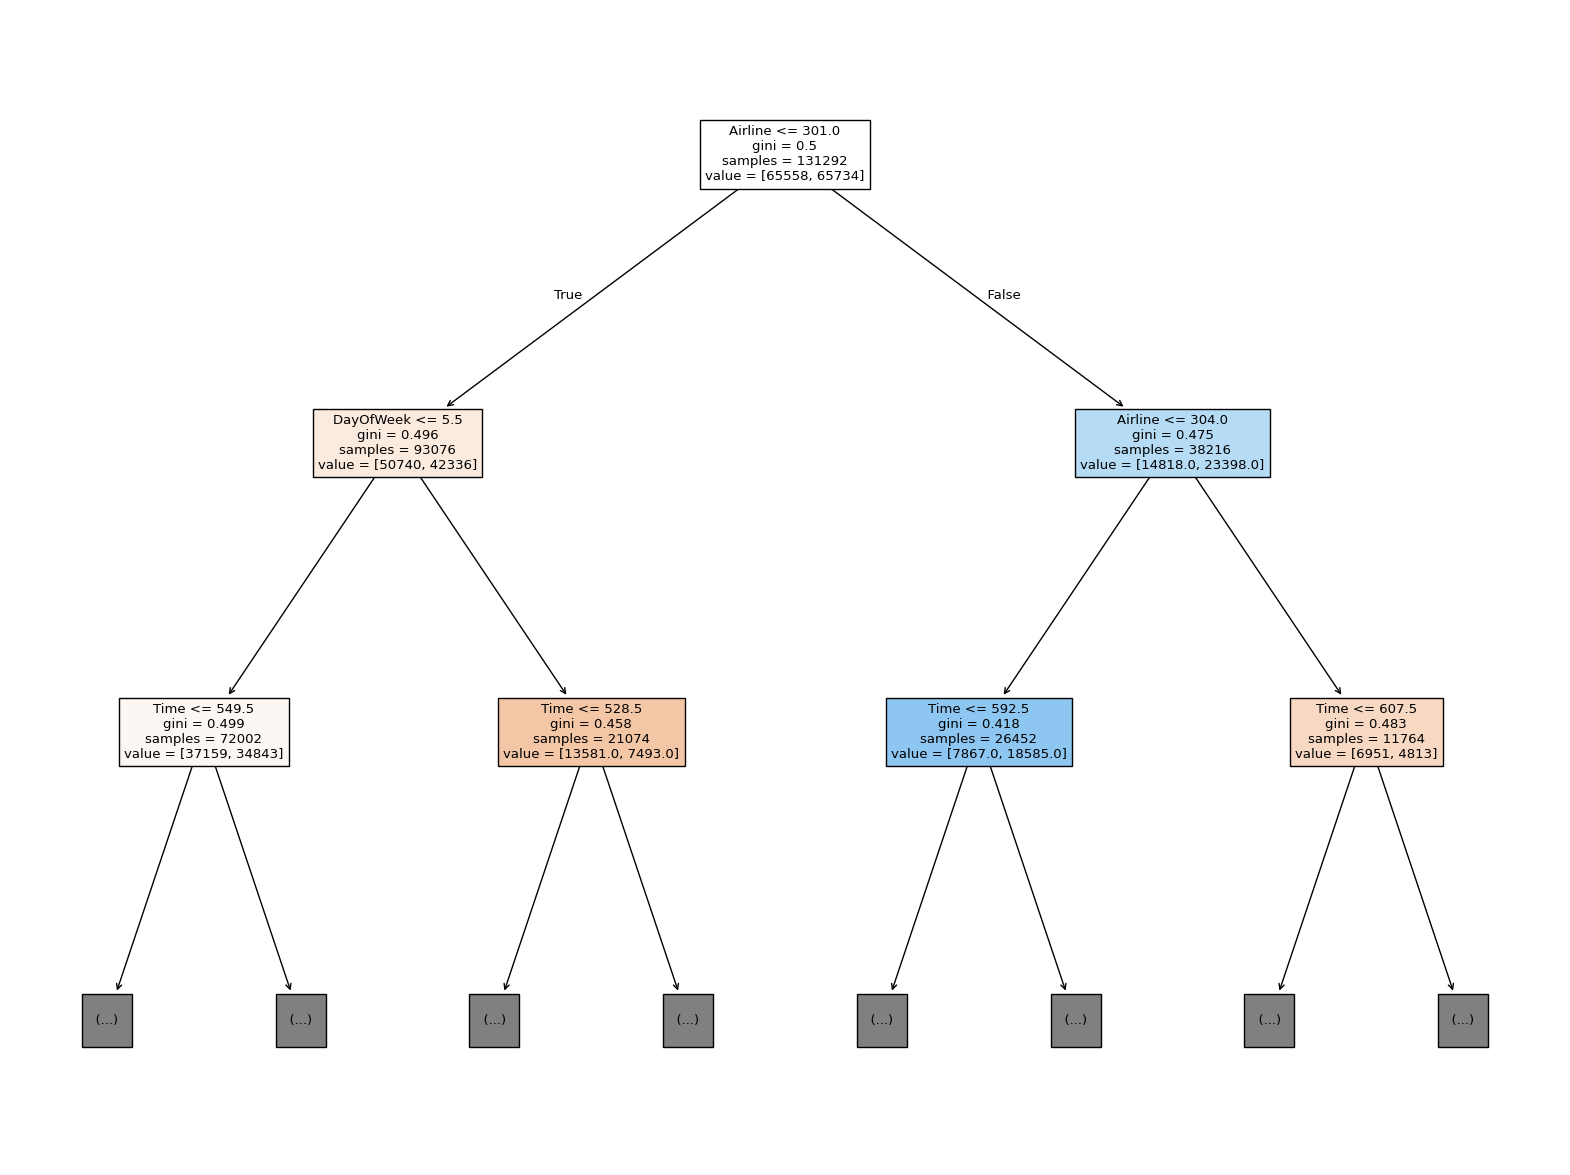

In [282]:
fig = plt.figure(figsize=(20,15))
plot_tree(dtc, max_depth=2, feature_names=X_cl.columns, filled=True)

[Text(0.5, 0.875, 'distance <= 0.023\nsquared_error = 164747.645\nsamples = 515146\nvalue = 682.183'),
 Text(0.25, 0.625, 'distance <= 0.013\nsquared_error = 79703.147\nsamples = 314592\nvalue = 486.86'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'distance <= 0.009\nsquared_error = 52899.906\nsamples = 159551\nvalue = 366.008'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'distance <= 0.018\nsquared_error = 76788.987\nsamples = 155041\nvalue = 611.227'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'distance <= 0.039\nsquared_error = 144431.879\nsamples = 200554\nvalue = 988.57'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'trip_hour <= 7.5\nsquared_error = 111543.666\nsamples = 119652\nvalue = 865.881'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'trip_hour <= 7.5\nsquared_error = 137884.847\nsamples = 80902\nv

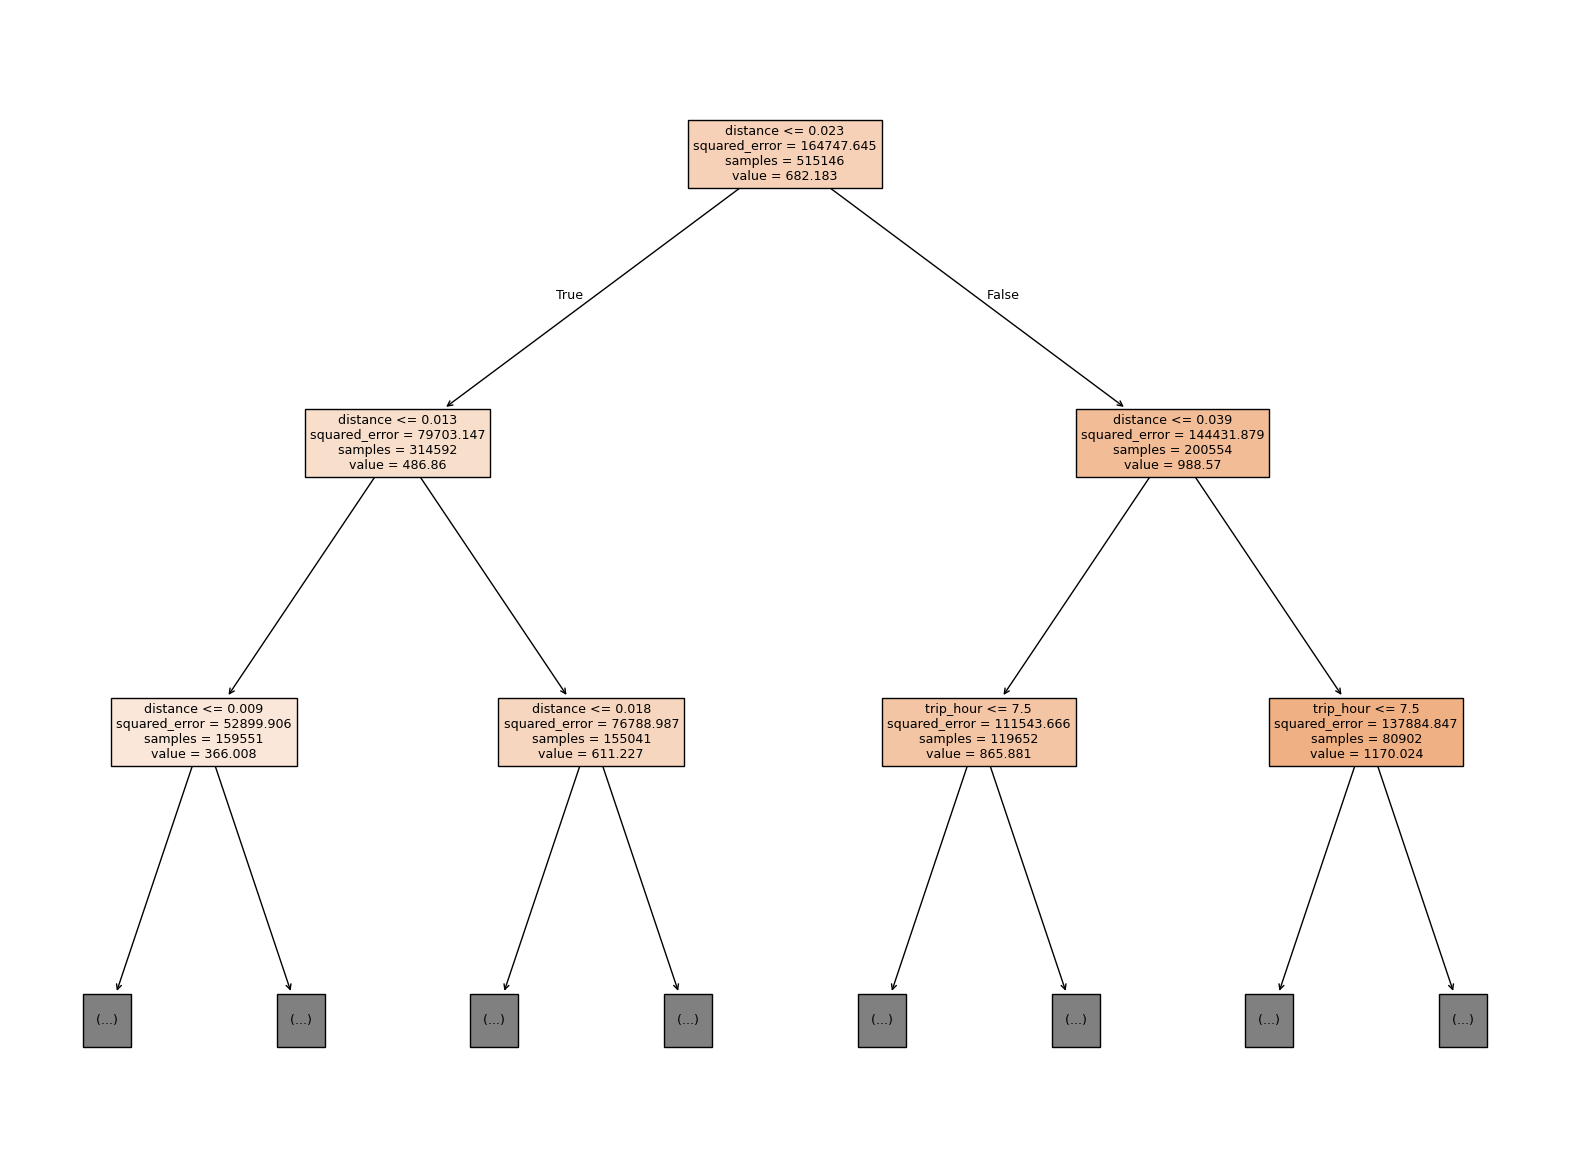

In [283]:
fig = plt.figure(figsize=(20,15))
plot_tree(dtr, max_depth=2, feature_names=X_reg.columns, filled=True)

In [335]:
columns = pd.MultiIndex.from_tuples([
    ("", "Алгоритм ML"),
    ("Train Data", "accuracy"), ("Train Data", "precision"), ("Train Data", "recall"), ("Train Data", "f1"),
    ("Test Data", "accuracy"), ("Test Data", "precision"), ("Test Data", "recall"), ("Test Data", "f1")
])

# Пример данных (все значения округлены до формата 0.XX)
data = [
    ["DT без регуляризации", round(dtc_non_reg_scores_train["accuracy"], 2), round(dtc_non_reg_scores_train["precision"], 2), round(dtc_non_reg_scores_train["recall"], 2), round(dtc_non_reg_scores_train["f1"], 2), round(dtc_non_reg_scores_test["accuracy"], 2), round(dtc_non_reg_scores_test["precision"], 2), round(dtc_non_reg_scores_test["recall"], 2), round(dtc_non_reg_scores_test["f1"], 2)],
    ["DT с регуляризацией", round(dtc_hold_scores_train["accuracy"], 2), round(dtc_hold_scores_train["precision"], 2), round(dtc_hold_scores_train["recall"], 2), round(dtc_hold_scores_train["f1"], 2), round(dtc_hold_scores_test["accuracy"], 2), round(dtc_hold_scores_test["precision"], 2), round(dtc_hold_scores_test["recall"], 2), round(dtc_hold_scores_test["f1"], 2)],
    ["Random Forest", round(random_forest_cl_scores_train["accuracy"], 2), round(random_forest_cl_scores_train["precision"], 2), round(random_forest_cl_scores_train["recall"], 2), round(random_forest_cl_scores_train["f1"], 2), round(random_forest_cl_scores_test["accuracy"], 2), round(random_forest_cl_scores_test["precision"], 2), round(random_forest_cl_scores_test["recall"], 2), round(dtc_hold_scores_test["f1"], 2)],
    ["Gradient Boosting", round(gbc_scores_train["accuracy"], 2), round(gbc_scores_train["precision"], 2), round(gbc_scores_train["recall"], 2), round(gbc_scores_train["f1"], 2), round(gbc_scores_test["accuracy"], 2), round(gbc_scores_test["precision"], 2), round(gbc_scores_test["recall"], 2), round(gbc_scores_test["f1"], 2)],
    ["Stacking", round(stacking_cl_scores_train["accuracy"], 2), round(stacking_cl_scores_train["precision"], 2), round(stacking_cl_scores_train["recall"], 2), round(stacking_cl_scores_train["f1"], 2), round(stacking_cl_scores_test["accuracy"], 2), round(stacking_cl_scores_test["precision"], 2), round(stacking_cl_scores_test["recall"], 2), round(stacking_cl_scores_test["f1"], 2)],
    ["CatBoost", round(scores_cat_boost_cl_train["accuracy"], 2), round(scores_cat_boost_cl_train["precision"], 2), round(scores_cat_boost_cl_train["recall"], 2), round(scores_cat_boost_cl_train["f1"], 2), round(scores_cat_boost_cl_test["accuracy"], 2), round(scores_cat_boost_cl_test["precision"], 2), round(scores_cat_boost_cl_test["recall"], 2), round(scores_cat_boost_cl_test["f1"], 2)],
    ["XGBoost", round(scores_XGBcl_train["accuracy"], 2), round(scores_XGBcl_train["precision"], 2), round(scores_XGBcl_train["recall"], 2), round(scores_XGBcl_train["f1"], 2), round(scores_XGBcl_test["accuracy"], 2), round(scores_XGBcl_test["precision"], 2), round(scores_XGBcl_test["recall"], 2), round(scores_XGBcl_test["f1"], 2)],
    ["LightGBM", round(LGBM_cl_scores_train["accuracy"], 2), round(LGBM_cl_scores_train["precision"], 2), round(LGBM_cl_scores_train["recall"], 2), round(LGBM_cl_scores_train["f1"], 2), round(LGBM_cl_scores_test["accuracy"], 2), round(LGBM_cl_scores_test["precision"], 2), round(LGBM_cl_scores_test["recall"], 2), round(LGBM_cl_scores_test["f1"], 2)],
]


res1 = pd.DataFrame(data, columns=columns)
res1

Train Data                        Test Data            \
            Алгоритм ML   accuracy precision recall    f1  accuracy precision   
0  DT без регуляризации       0.90      1.00   0.79  0.88      0.47      0.47   
1   DT с регуляризацией       0.63      0.63   0.61  0.62      0.63      0.63   
2         Random Forest       0.65      0.66   0.60  0.63      0.63      0.64   
3     Gradient Boosting       0.67      0.67   0.65  0.66      0.63      0.64   
4              Stacking       0.66      0.67   0.63  0.65      0.63      0.64   
5              CatBoost       0.68      0.69   0.65  0.67      0.66      0.67   
6               XGBoost       0.65      0.66   0.65  0.65      0.63      0.62   
7              LightGBM       0.65      0.66   0.62  0.64      0.64      0.65   

                
  recall    f1  
0   0.44  0.45  
1   0.61  0.62  
2   0.58  0.62  
3   0.62  0.63  
4   0.59  0.61  
5   0.64  0.65  
6   0.62  0.62  
7   0.61  0.63

In [336]:
columns = pd.MultiIndex.from_tuples([
    ("", "Алгоритм ML"),
    ("Train Data", "mse"), ("Train Data", "mae"), ("Train Data", "rmse"), ("Train Data", "mape"), ("Train Data", "r2"),
    ("Test Data", "mse"), ("Test Data", "mae"), ("Test Data", "rmse"), ("Test Data", "mape"), ("Test Data", "r2"),
])

data = [
    ["DT без регуляризации", round(dtr_non_reg_scores_train["mse"], 2), round(dtr_non_reg_scores_train["mae"], 2), round(dtr_non_reg_scores_train["rmse"], 2), round(dtr_non_reg_scores_train["mape"], 2), round(dtr_non_reg_scores_train["r2"], 2), round(dtr_non_reg_scores_test["mse"], 2), round(dtr_non_reg_scores_test["mae"], 2), round(dtr_non_reg_scores_test["rmse"], 2), round(dtr_non_reg_scores_test["mape"], 2), round(dtr_non_reg_scores_test["r2"], 2)],
    ["DT с регуляризацией", round(dtr_hold_scores_train["mse"], 2), round(dtr_hold_scores_train["mae"], 2), round(dtr_hold_scores_train["rmse"], 2), round(dtr_hold_scores_train["mape"], 2), round(dtr_hold_scores_train["r2"], 2), round(dtr_hold_scores_test["mse"], 2), round(dtr_hold_scores_test["mae"], 2), round(dtr_hold_scores_test["rmse"], 2), round(dtr_hold_scores_test["mape"], 2), round(dtr_hold_scores_test["r2"], 2)],
    ["Random Forest", round(bagging_reg_scores_train["mse"], 2), round(bagging_reg_scores_train["mae"], 2), round(bagging_reg_scores_train["rmse"], 2), round(bagging_reg_scores_train["mape"], 2), round(bagging_reg_scores_train["r2"], 2), round(bagging_reg_scores_test["mse"], 2), round(bagging_reg_scores_test["mae"], 2), round(bagging_reg_scores_test["rmse"], 2), round(bagging_reg_scores_test["mape"], 2), round(bagging_reg_scores_test["r2"], 2)],
    ["Gradient Boosting", round(gbr_scores_train["mse"], 2), round(gbr_scores_train["mae"], 2), round(gbr_scores_train["rmse"], 2), round(gbr_scores_train["mape"], 2), round(gbr_scores_train["r2"], 2), round(gbr_scores_test["mse"], 2), round(gbr_scores_test["mae"], 2), round(gbr_scores_test["rmse"], 2), round(gbr_scores_test["mape"], 2), round(gbr_scores_test["r2"], 2)],
    ["Stacking", round(stacking_reg_scores_train["mse"], 2), round(stacking_reg_scores_train["mae"], 2), round(stacking_reg_scores_train["rmse"], 2), round(stacking_reg_scores_train["mape"], 2), round(stacking_reg_scores_train["r2"], 2), round(stacking_reg_scores_test["mse"], 2), round(stacking_reg_scores_test["mae"], 2), round(stacking_reg_scores_test["rmse"], 2), round(stacking_reg_scores_test["mape"], 2), round(stacking_reg_scores_test["r2"], 2)],
    ["CatBoost", round(scores_cat_boost_reg_train["mse"], 2), round(scores_cat_boost_reg_train["mae"], 2), round(scores_cat_boost_reg_train["rmse"], 2), round(scores_cat_boost_reg_train["mape"], 2), round(scores_cat_boost_reg_train["r2"], 2), round(scores_cat_boost_reg_test["mse"], 2), round(scores_cat_boost_reg_test["mae"], 2), round(scores_cat_boost_reg_test["rmse"], 2), round(scores_cat_boost_reg_test["mape"], 2), round(scores_cat_boost_reg_test["r2"], 2)],
    ["XGBoost", round(scores_XGBreg_train["mse"], 2), round(scores_XGBreg_train["mae"], 2), round(scores_XGBreg_train["rmse"], 2), round(scores_XGBreg_train["mape"], 2), round(scores_XGBreg_train["r2"], 2), round(scores_XGBreg_test["mse"], 2), round(scores_XGBreg_train["mae"], 2), round(scores_XGBreg_train["rmse"], 2), round(scores_XGBreg_train["mape"], 2), round(scores_XGBreg_train["r2"], 2)],
    ["LightGBM", round(LGBM_reg_scores_train["mse"], 2), round(LGBM_reg_scores_train["mae"], 2), round(LGBM_reg_scores_train["rmse"], 2), round(LGBM_reg_scores_train["mape"], 2), round(LGBM_reg_scores_train["r2"], 2), round(LGBM_reg_scores_test["mse"], 2), round(LGBM_reg_scores_test["mae"], 2), round(LGBM_reg_scores_test["rmse"], 2), round(LGBM_reg_scores_test["mape"], 2), round(LGBM_reg_scores_test["r2"], 2)],
]

res2 = pd.DataFrame(data, columns=columns)
res2

Train Data                             Test Data  \
            Алгоритм ML        mse     mae    rmse  mape    r2       mse   
0  DT без регуляризации       0.00    0.00    0.00  0.00  1.00  95188.30   
1   DT с регуляризацией   46460.28  155.69  215.55  0.34  0.72  54849.18   
2         Random Forest   44877.89  152.46  211.84  0.34  0.73  49770.06   
3     Gradient Boosting   23979.35  109.81  154.85  0.23  0.85  42929.31   
4              Stacking   33683.74  131.98  183.53  0.30  0.80  51446.57   
5              CatBoost   42663.59  148.12  206.55  0.34  0.74  44305.12   
6               XGBoost   50807.28  163.87  225.40  0.39  0.69  51729.39   
7              LightGBM   53033.33  167.47  230.29  0.39  0.68  53179.50   

                               
      mae    rmse  mape    r2  
0  219.60  308.53  0.45  0.42  
1  169.63  234.20  0.37  0.67  
2  160.77  223.09  0.36  0.70  
3  147.53  207.19  0.33  0.74  
4  163.27  226.82  0.36  0.69  
5  150.56  210.49  0.35  0.73  
6  163.87  225.40  0.39  0.69  
7  167.56  230.61  0.39  0.68

In [337]:
with open(r"../../models/Lab4 (Tree)/results1.pkl", "wb") as f:
    pickle.dump(res1, f)
with open(r"../../models/Lab4 (Tree)/results2.pkl", "wb") as f:
    pickle.dump(res2, f)

In [338]:
columns = pd.MultiIndex.from_tuples([
    ("", "Алгоритм ML"),
    ("hold out", "accuracy"), ("hold out", "precision"), ("hold out", "recall"), ("hold out", "f1"),
    ("k-fold", "accuracy"), ("k-fold", "precision"), ("k-fold", "recall"), ("k-fold", "f1")
])

# Пример данных (все значения округлены до формата 0.XX)
data = [
    ["Decision Tree", round(dtc_hold_scores_test["accuracy"], 2), round(dtc_hold_scores_test["precision"], 2), round(dtc_hold_scores_test["recall"], 2), round(dtc_hold_scores_test["f1"], 2), dtc_test_cross_val["accuracy"], round(dtc_test_cross_val["precision"], 2), round(dtc_test_cross_val["recall"], 2), round(dtc_test_cross_val["f1"], 2)],
    ["Random Forest", round(random_forest_cl_scores_test["accuracy"], 2), round(random_forest_cl_scores_test["precision"], 2), round(random_forest_cl_scores_test["recall"], 2), round(dtc_hold_scores_test["f1"], 2), round(cv_Bagging_cl_scores["accuracy"], 2), round(cv_Bagging_cl_scores["precision"], 2), round(cv_Bagging_cl_scores["recall"], 2), round(cv_Bagging_cl_scores["f1"], 2)],
    ["Gradient Boosting", round(gbc_scores_test["accuracy"], 2), round(gbc_scores_test["precision"], 2), round(gbc_scores_test["recall"], 2), round(gbc_scores_test["f1"], 2), round(cv_GB_cl_scores["accuracy"], 2), round(cv_GB_cl_scores["precision"], 2), round(cv_GB_cl_scores["recall"], 2), round(cv_GB_cl_scores["f1"], 2)],
    ["Stacking", round(stacking_cl_scores_test["accuracy"], 2), round(stacking_cl_scores_test["precision"], 2), round(stacking_cl_scores_test["recall"], 2), round(stacking_cl_scores_test["f1"], 2), round(cv_Stacking_cl_scores["accuracy"], 2), round(cv_Stacking_cl_scores["precision"], 2), round(cv_Stacking_cl_scores["recall"], 2), round(cv_Stacking_cl_scores["f1"], 2)],
    ["CatBoost", round(scores_cat_boost_cl_test["accuracy"], 2), round(scores_cat_boost_cl_test["precision"], 2), round(scores_cat_boost_cl_test["recall"], 2), round(scores_cat_boost_cl_test["f1"], 2), round(cv_CBcl_scores["accuracy"], 2), round(cv_CBcl_scores["precision"], 2), round(cv_CBcl_scores["recall"], 2), round(cv_CBcl_scores["f1"], 2)],
    ["XGBoost", round(scores_XGBcl_test["accuracy"], 2), round(scores_XGBcl_test["precision"], 2), round(scores_XGBcl_test["recall"], 2), round(scores_XGBcl_test["f1"], 2), round(cv_XGBcl_scores["accuracy"], 2), round(cv_XGBcl_scores["precision"], 2), round(cv_XGBcl_scores["recall"], 2), round(cv_XGBcl_scores["f1"], 2)],
    ["LightGBM", round(LGBM_cl_scores_test["accuracy"], 2), round(LGBM_cl_scores_test["precision"], 2), round(LGBM_cl_scores_test["recall"], 2), round(LGBM_cl_scores_test["f1"], 2), round(cv_LGBM_cl_scores["accuracy"], 2), round(cv_LGBM_cl_scores["precision"], 2), round(cv_LGBM_cl_scores["recall"], 2), round(cv_LGBM_cl_scores["f1"], 2)],
]


res3 = pd.DataFrame(data, columns=columns)
res3

hold out                          k-fold            \
         Алгоритм ML accuracy precision recall    f1 accuracy precision   
0      Decision Tree     0.63      0.63   0.61  0.62     0.61      0.62   
1      Random Forest     0.63      0.64   0.58  0.62     0.63      0.64   
2  Gradient Boosting     0.63      0.64   0.62  0.63     0.63      0.64   
3           Stacking     0.63      0.64   0.59  0.61     0.62      0.64   
4           CatBoost     0.66      0.67   0.64  0.65     0.66      0.67   
5            XGBoost     0.63      0.62   0.62  0.62     0.62      0.63   
6           LightGBM     0.64      0.65   0.61  0.63     0.63      0.64   

                
  recall    f1  
0   0.59  0.60  
1   0.59  0.61  
2   0.62  0.63  
3   0.58  0.61  
4   0.64  0.65  
5   0.61  0.62  
6   0.61  0.62

In [339]:
columns = pd.MultiIndex.from_tuples([
    ("", "Алгоритм ML"),
    ("hold out", "MSE"), ("hold out", "MAE"), ("hold out", "RMSE"), ("hold out", "MAPE"), ("hold out", "R2"),
    ("k-fold", "MSE"), ("k-fold", "MAE"), ("k-fold", "RMSE"), ("k-fold", "MAPE"), ("k-fold", "R2"),
])

# Пример данных (все значения округлены до формата 0.XX)
data = [
    ["Decision Tree", round(dtr_hold_scores_test["mse"], 2), round(dtr_hold_scores_test["mae"], 2), round(dtr_hold_scores_test["rmse"], 2), round(dtr_hold_scores_test["mape"], 2), round(dtr_hold_scores_test["r2"], 2), dtr_test_cross_val["mse"], round(dtr_test_cross_val["mae"], 2), round(dtr_test_cross_val["rmse"], 2), round(dtr_test_cross_val["mape"], 2), round(dtr_test_cross_val["mape"], 2)],
["Random Forest", round(bagging_reg_scores_test["mse"], 2), round(bagging_reg_scores_test["mae"], 2), round(bagging_reg_scores_test["rmse"], 2), round(bagging_reg_scores_test["mape"], 2), round(bagging_reg_scores_test["r2"], 2), round(cv_Bagging_reg_scores["MSE"], 2), round(cv_Bagging_reg_scores["MAE"], 2), round(cv_Bagging_reg_scores["RMSE"], 2), round(cv_Bagging_reg_scores["MAPE"], 2), round(cv_Bagging_reg_scores["R2"], 2)],
["Gradient Boosting", round(gbr_scores_test["mse"], 2), round(gbr_scores_test["mae"], 2), round(gbr_scores_test["rmse"], 2), round(gbr_scores_test["mape"], 2), round(gbr_scores_test["r2"], 2), round(cv_GB_reg_scores["MSE"], 2), round(cv_GB_reg_scores["MAE"], 2), round(cv_GB_reg_scores["RMSE"], 2), round(cv_GB_reg_scores["MAPE"], 2), round(cv_GB_reg_scores["R2"], 2)],
["Stacking", round(stacking_reg_scores_test["mse"], 2), round(stacking_reg_scores_test["mae"], 2), round(stacking_reg_scores_test["rmse"], 2), round(stacking_reg_scores_test["mape"], 2), round(stacking_reg_scores_test["r2"], 2), round(cv_Stacking_reg_scores["MSE"], 2), round(cv_Stacking_reg_scores["MAE"], 2), round(cv_Stacking_reg_scores["RMSE"], 2), round(cv_Stacking_reg_scores["MAPE"], 2), round(cv_Stacking_reg_scores["R2"], 2)],
["CatBoost", round(scores_cat_boost_reg_test["mse"], 2), round(scores_cat_boost_reg_test["mae"], 2), round(scores_cat_boost_reg_test["rmse"], 2), round(scores_cat_boost_reg_test["mape"], 2), round(scores_cat_boost_reg_test["r2"], 2), round(cv_CBreg_scores["MSE"], 2), round(cv_CBreg_scores["MAE"], 2), round(cv_CBreg_scores["RMSE"], 2), round(cv_CBreg_scores["MAPE"], 2), round(cv_CBreg_scores["R2"], 2)],
["XGBoost", round(scores_XGBreg_test["mse"], 2), round(scores_XGBreg_test["mae"], 2), round(scores_XGBreg_test["rmse"], 2), round(scores_XGBreg_test["mape"], 2), round(scores_XGBreg_test["r2"], 2), round(cv_XGBreg_scores["MSE"], 2), round(cv_XGBreg_scores["MAE"], 2), round(cv_XGBreg_scores["RMSE"], 2), round(cv_XGBreg_scores["MAPE"], 2), round(cv_XGBreg_scores["R2"], 2)],
["LightGBM", round(LGBM_reg_scores_test["mse"], 2), round(LGBM_reg_scores_test["mae"], 2), round(LGBM_reg_scores_test["rmse"], 2), round(LGBM_reg_scores_test["mape"], 2), round(LGBM_reg_scores_test["r2"], 2), round(cv_LGBM_reg_scores["MSE"], 2), round(cv_LGBM_reg_scores["MAE"], 2), round(cv_LGBM_reg_scores["RMSE"], 2), round(cv_LGBM_reg_scores["MAPE"], 2), round(cv_LGBM_reg_scores["R2"], 2)],
]


res4 = pd.DataFrame(data, columns=columns)
res4

hold out                                k-fold          \
         Алгоритм ML       MSE     MAE    RMSE  MAPE    R2       MSE     MAE   
0      Decision Tree  54849.18  169.63  234.20  0.37  0.67  54480.52  168.89   
1      Random Forest  49770.06  160.77  223.09  0.36  0.70  50432.07  162.06   
2  Gradient Boosting  42929.31  147.53  207.19  0.33  0.74  42898.13  147.46   
3           Stacking  51446.57  163.27  226.82  0.36  0.69  51274.66  163.18   
4           CatBoost  44305.12  150.56  210.49  0.35  0.73  44375.28  150.82   
5            XGBoost  51729.39  165.25  227.44  0.40  0.69  51630.23  165.23   
6           LightGBM  53179.50  167.56  230.61  0.39  0.68  53195.11  167.64   

                       
     RMSE  MAPE    R2  
0  233.41  0.37  0.37  
1  224.57  0.36  0.69  
2  207.12  0.33  0.74  
3  226.44  0.36  0.69  
4  210.65  0.35  0.73  
5  227.22  0.40  0.69  
6  230.64  0.39  0.68

In [340]:
with open(r"../../models/Lab4 (Tree)/results3.pkl", "wb") as f:
    pickle.dump(res3, f)
with open(r"../../models/Lab4 (Tree)/results4.pkl", "wb") as f:
    pickle.dump(res4, f)

# PyCaret

In [2]:
!pip install --pre pycaret

  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached pyod-2.0.5-py3-none-any.whl.metadata (46 kB)
  Using cached matplotlib-3.7.5-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached yellowbrick-1.5-py3-none-any.whl.metadata (7.7 kB)
  Using cached sktime-0.26.0-py3-none-any.whl.metadata (29 kB)
  Using cached tbats-1.1.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached pmdarima-2.0.4-cp312-cp312-win_amd64.whl.metadata (8.0 kB)
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
  Using cached category_encoders-2.8.1-py3-none-any.whl.metadata (7.9 kB)
  Using cached category_encoders-2.7.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached dash-3.0.4-py3-none-any.whl.metadata (10 kB)
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
Using cached pycaret-3.3.2-py3-none-any.whl 


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pycaret

RuntimeError: ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=0, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')

# Вывод
Древесные модели показали себя лучше чем линейные. Лучшими моделями оказались Gradient Boosting. 

Лучшая модель классификации: CatBoost
Лучшая модель регрессии: GradientBoostingClassifier

Это связано с тем, что модели градиентного бустинга являются наиболее сильными, если не считать нейросетевые модели